## Uso del Modelo SARIMA y el alisado Exponencial para la predicción de uso de CPU


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

### MODELO ARIMA

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


<Figure size 640x480 with 0 Axes>

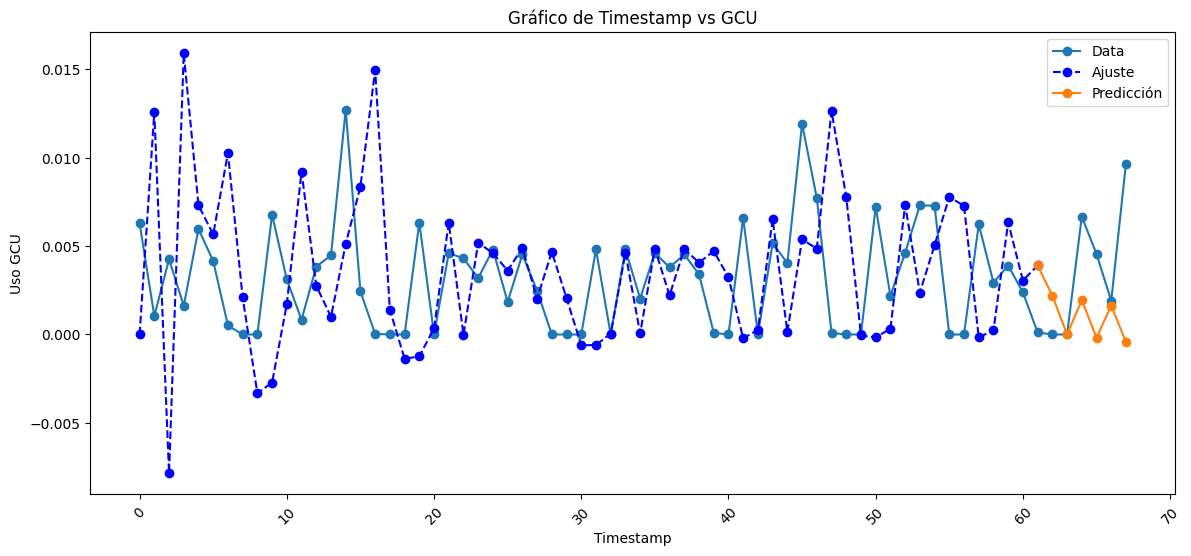

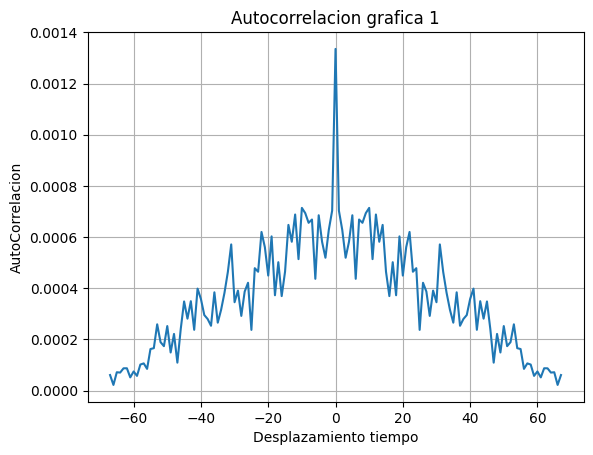

/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2821: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2680: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)


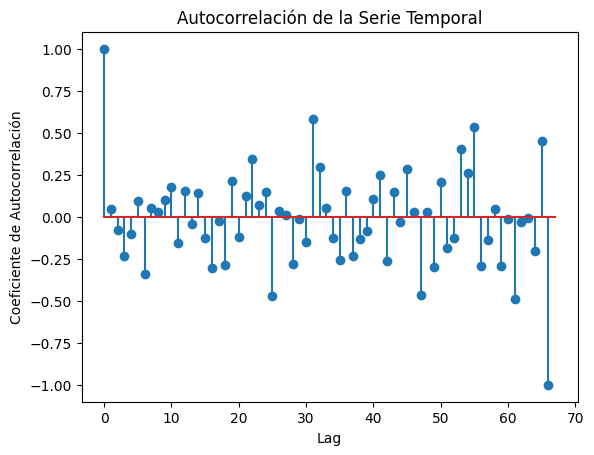

In [ ]:

# Leer el archivo CSV
data = pd.read_csv('data-server.csv')
#print(data)
# Convertir el campo "timestamp" a formato de fecha y hora
data['time'] = data.index
# Tamaño data[time]
len_data=len(data['cpu'])

#Prediccion a través de ARIMA
ajuste_start=0
ajuste_end=len_data-7
prediccion_start = len_data-7
prediccion_end = len_data-1

series_ajuste = data['cpu'][ajuste_start:ajuste_end+1]
model = sm.tsa.ARIMA(series_ajuste, order=(1, 3, 2))
model_fit = model.fit()

series_prediccion = data['cpu'][prediccion_start:prediccion_end+1]
forecast = model_fit.predict(start=prediccion_start, end=prediccion_end)

# Graficar timestamp vs avg cpu
plt.figure(0)
plt.figure(figsize=(14,6))
plt.plot(data['time'], data['cpu'],"-o",label='Data')

plt.plot(data['time'][ajuste_start:ajuste_end+1], model_fit.fittedvalues,"--bo", label='Ajuste')
plt.plot(data['time'][prediccion_start:prediccion_end+1], forecast,"-o", label='Predicción')

plt.xlabel('Timestamp')
#“Google compute units” (GCUs)
plt.ylabel('Uso GCU')
plt.title('Gráfico de Timestamp vs GCU')
plt.legend()
plt.xticks(rotation=45)  # Rotar las etiquetas del eje x si es necesario
plt.show()



#Calculando autocorrelacion
# Calculando la autocorrelacion de la señal 1
r11 = np.correlate(data['cpu'],data['cpu'],mode='full')

# Calcular el desplazamiento temporal
lag2 = np.arange(-(len(data['cpu'])-1), len(data['cpu']))

plt.figure(1)
plt.plot(lag2,r11,label='r12[n]')
plt.grid()
plt.title("Autocorrelacion grafica 1")
plt.xlabel("Desplazamiento tiempo")
plt.ylabel("AutoCorrelacion")
plt.show()


# Autocorrelación con Pandas
lags = range(len(data['cpu']))
autocorr = data['cpu'].autocorr()

autocorr_values = [data['cpu'].autocorr(lag) for lag in lags]

# Graficar del coeficiente de autocorrelación
plt.figure(2)
plt.stem(lags, autocorr_values)
plt.xlabel("Lag")
plt.ylabel("Coeficiente de Autocorrelación")
plt.title("Autocorrelación de la Serie Temporal")
plt.show()

El modelo ARIMA solo consigue predicción para un par de muestras al futuro, y su implementación requiere que el algoritmo este en constante cálculo, lo que significa un alto consumo de recursos, por lo que preferirá ir por un modelo que consiga resultados a largo plazo. Por lo que respecto a usos anomalos no detectados, será el monitoreo de recursos quien se encarge de iniciar la migración en esos casos.

### PREDICCION DE UNA SERIE CON COMPONENTE ESTACIONARIA






Fuentes:

[Time series components](https://https://otexts.com/fpp2/components.html)

$$y_{t} = S_{t} + T_{t} + R_t$$

$$y_{t}: \textrm{Serie de tiempo}$$
$$S_{t}: \textrm{Componente estacional}$$
$$T_{t}: \textrm{Componente de tendencia}$$
$$R_{t}: \textrm{Componente de residuo}$$

Se presupone una serie de tiempo con periodo de 290 muestras


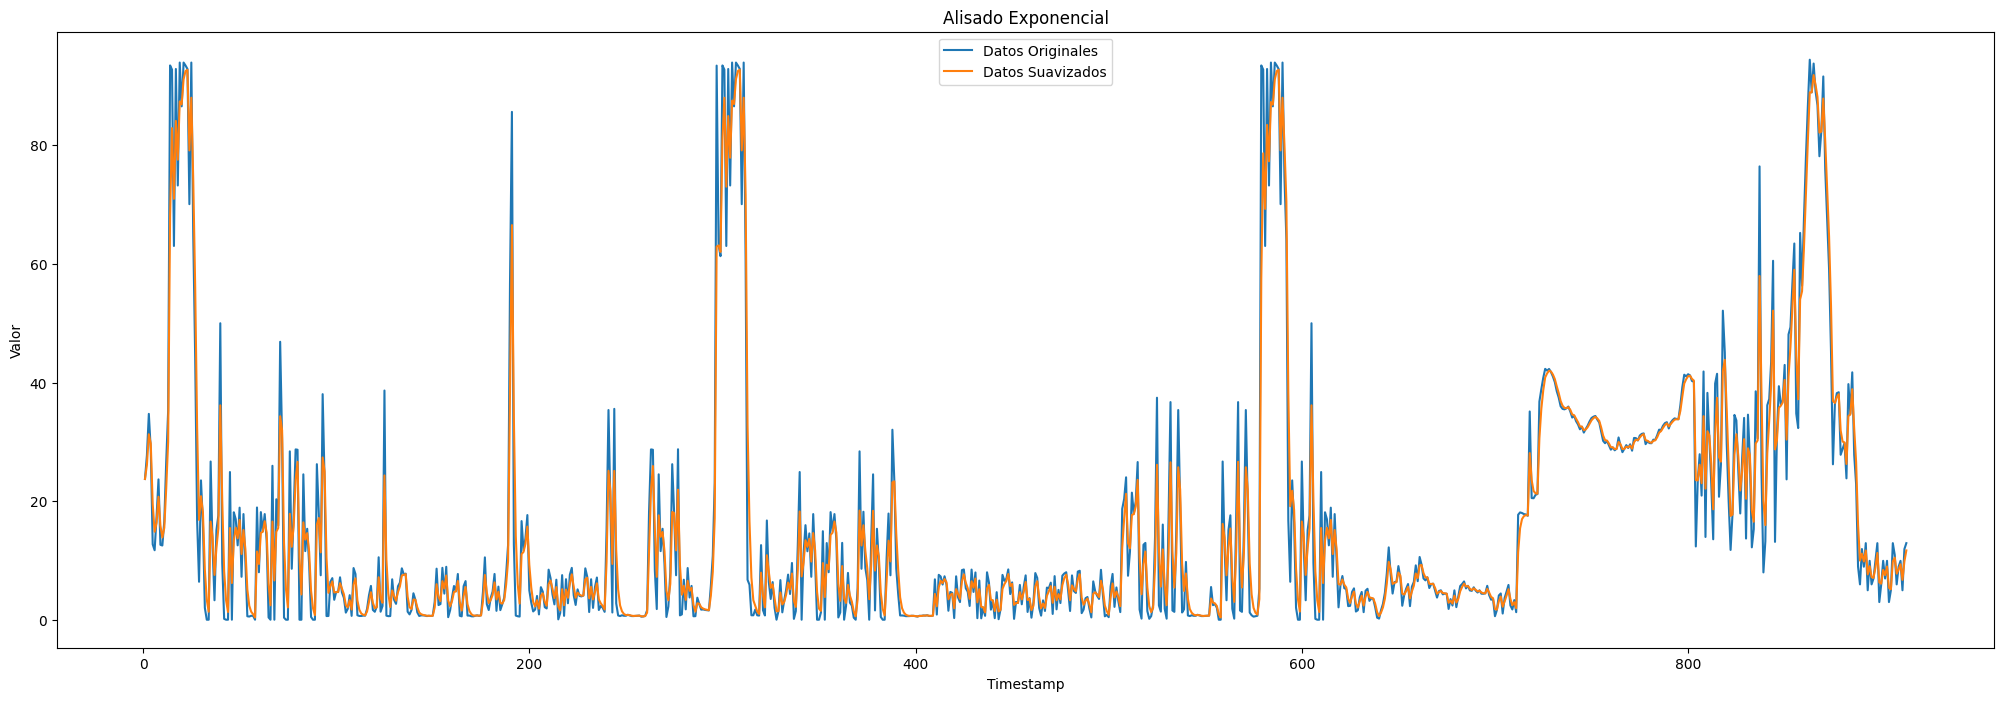

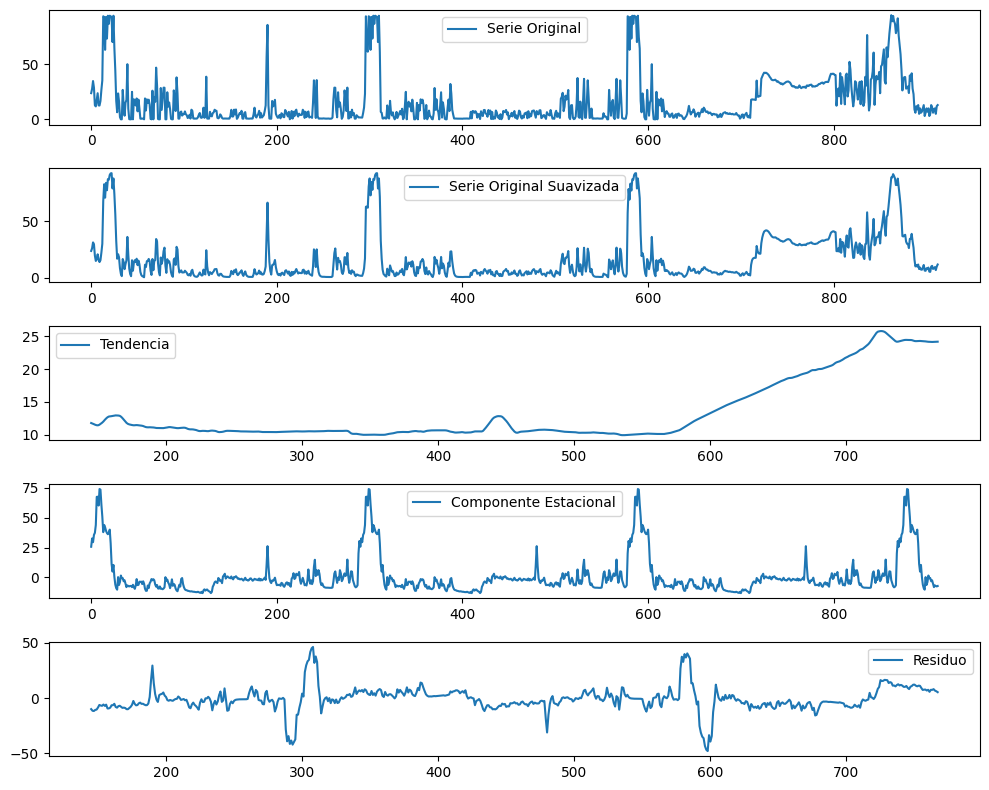

In [2]:
# Cargar datos desde el archivo CSV
#data = pd.read_csv('noisecpu1.csv')
data = pd.read_csv('data_dit6.csv')

# Aplicar alisado exponencial con factor de suavizado alpha
alpha = 0.6  # Valor de factor de suavizado (0 < alpha < 1)
data['smoothed_data'] = data['cpu_usage'].ewm(alpha=alpha, adjust=False).mean()

# Graficar datos originales y suavizados

plt.figure(figsize=(25, 8))
plt.plot(data['time'], data['cpu_usage'], label='Datos Originales')
plt.plot(data['time'], data['smoothed_data'], label='Datos Suavizados')
plt.xlabel('Timestamp')
plt.ylabel('Valor')
plt.title('Alisado Exponencial')
plt.legend()
plt.show()



# Realizar la descomposición de la serie temporal
decomposition = sm.tsa.seasonal_decompose(data['smoothed_data'], model='additive',period = 290)

# Obtener la componente estacional, la tendencia y el residuo
seasonal = decomposition.seasonal
trend = decomposition.trend
residual = decomposition.resid

# Graficar los componentes
plt.figure(figsize=(10, 8))
plt.subplot(5, 1, 1)
plt.plot(data['cpu_usage'], label='Serie Original')
plt.legend()
plt.subplot(5, 1, 2)
plt.plot(data['smoothed_data'], label='Serie Original Suavizada')
plt.legend()
plt.subplot(5, 1, 3)
plt.plot(trend, label='Tendencia')
plt.legend()
plt.subplot(5, 1, 4)
plt.plot(seasonal, label='Componente Estacional')
plt.legend()
plt.subplot(5, 1, 5)
plt.plot(residual, label='Residuo')
plt.legend()

# Ajustar el espaciado entre subplots
plt.tight_layout()

# Mostrar el gráfico
plt.show()

Con la componente estacional calculada se extiende a más valores

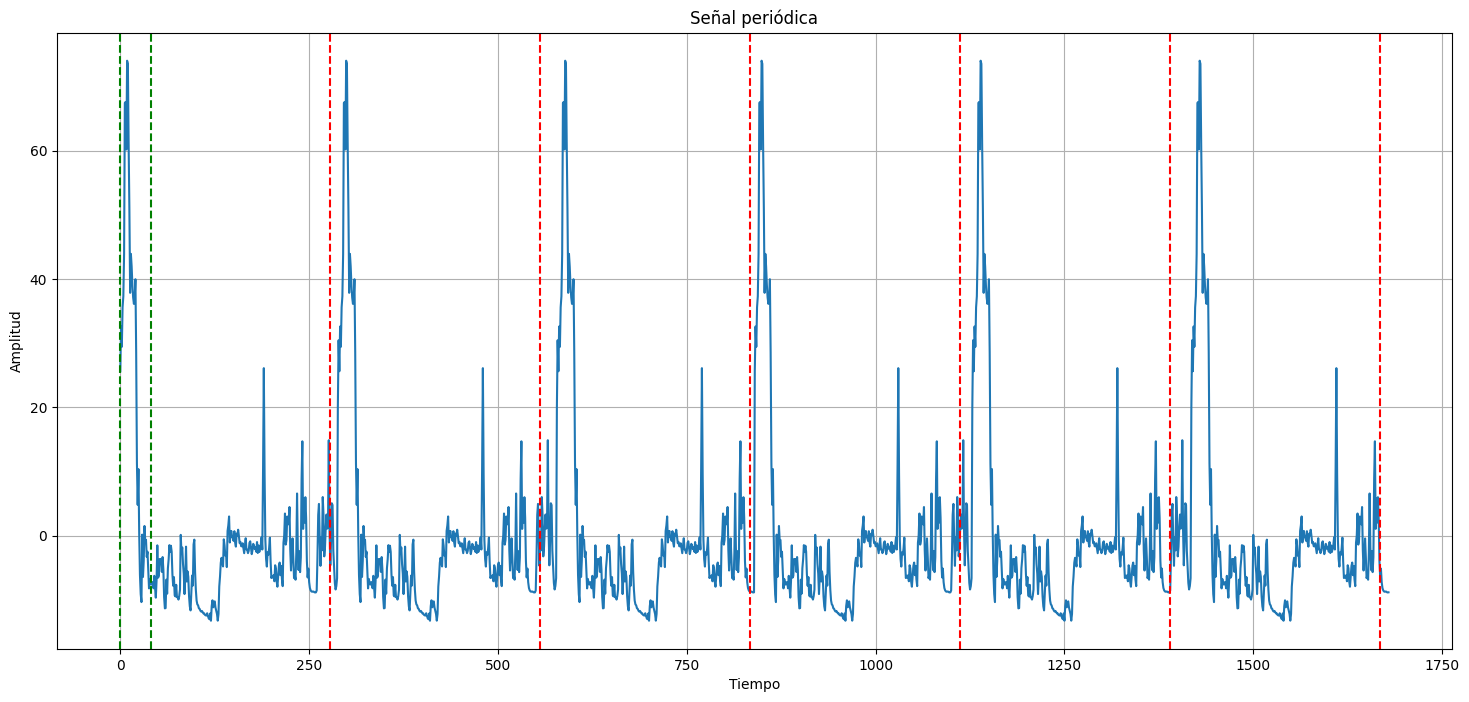

In [3]:
# Extensión de la componente estacional
plt.figure(figsize=(18, 8))
repeated_signal = np.tile(seasonal[0:840], 2)
plt.plot(repeated_signal)
plt.xlabel('Tiempo')
plt.ylabel('Amplitud')
plt.title('Señal periódica')
plt.grid(True)
plt.axvline(x=0, color='g', linestyle='--')
plt.axvline(x=40, color='g', linestyle='--')
# Agregar líneas verticales cada 100 puntos
for i in range(1, 7):
    plt.axvline(x=i*278, color='r', linestyle='--')
plt.show()

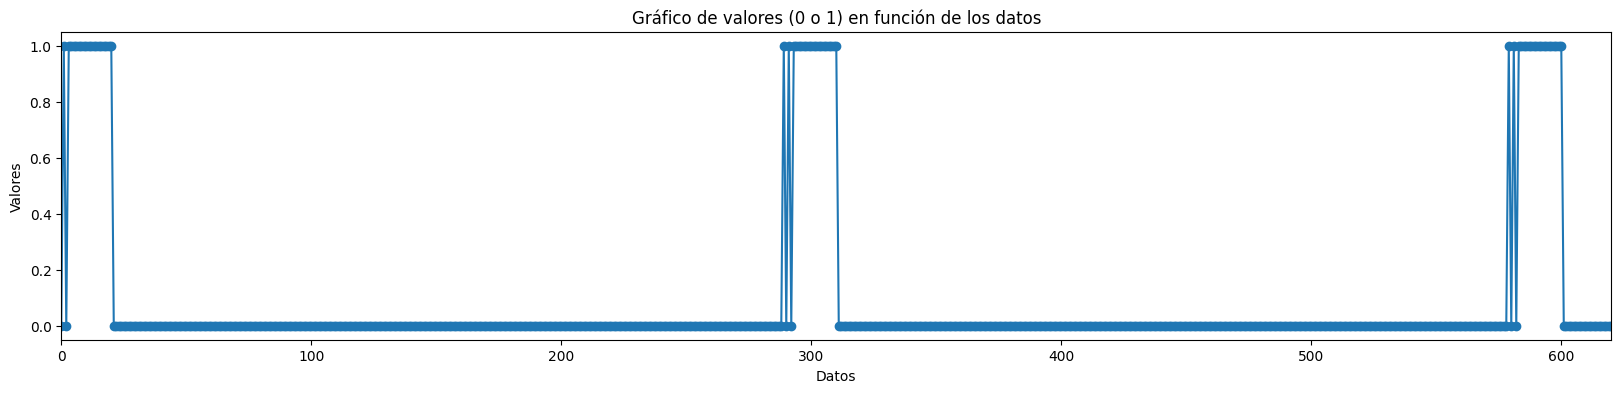

In [4]:
# Aplicar la condición y asignar los valores correspondientes
valores = np.where(repeated_signal < 30, 0, 1)

# Graficar los valores
plt.figure(figsize=(20, 4))
plt.plot(valores, '-o')
plt.xlim(0,620)
plt.xlabel('Datos')
plt.ylabel('Valores')
plt.title('Gráfico de valores (0 o 1) en función de los datos')
plt.show()

Se aplica suavizado exponencial a la muestra

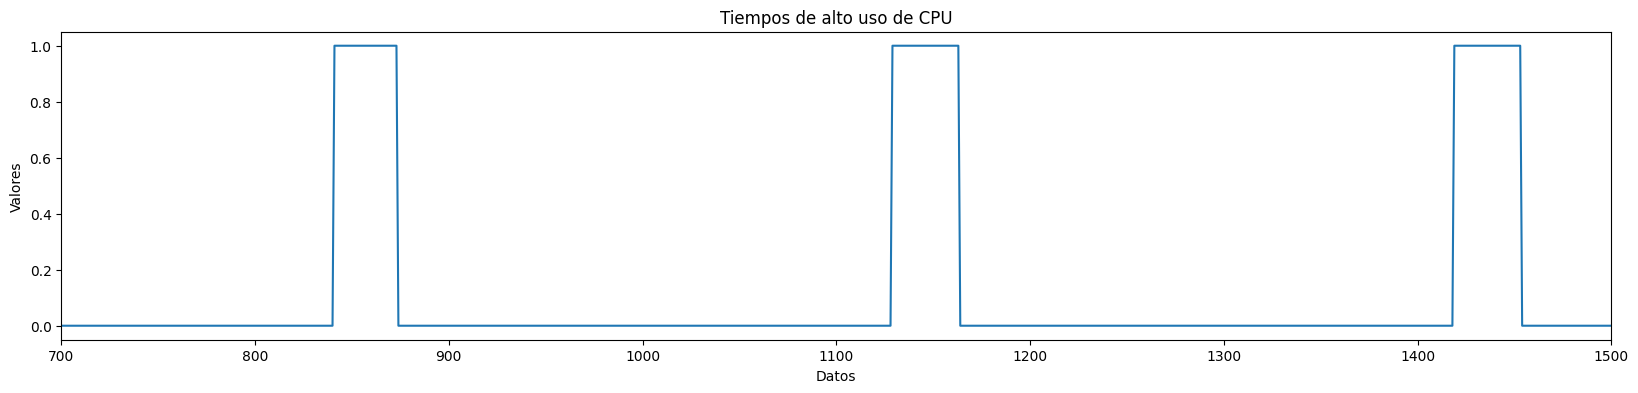

In [7]:
alpha2 = 0.15  # Valor de factor de suavizado (0 < alpha < 1)
data_pandas = pd.DataFrame(valores)
valores_continuos = data_pandas.ewm(alpha=alpha2, adjust=False).mean()
valores_continuos2 = np.where(valores_continuos < 0.1, 0, 1)
# Graficar los valores
plt.figure(figsize=(20, 4))
plt.plot(valores_continuos2, '-')
plt.xlim(700,1500)
plt.xlabel('Datos')
plt.ylabel('Valores')
plt.title('Tiempos de alto uso de CPU')
plt.show()